In [ ]:
mount = '/content/gdrive'
from google.colab import drive
drive.mount(mount)

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np

mask = cv2.imread("/content/gdrive/MyDrive/masks/001_HC_Annotation.png", cv2.IMREAD_GRAYSCALE)


print("Shape:", mask.shape)
print("Unique values:", np.unique(mask))


Shape: (540, 800)
Unique values: [  0 255]


In [ ]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class FetalSkullSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size

        self.image_names = sorted([
            f for f in os.listdir(img_dir)
            if f.endswith(".png")
        ])

        print(f"Total images found: {len(self.image_names)}")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]

        # Image path
        img_path = os.path.join(self.img_dir, img_name)

        # Mask name mapping
        base_name = img_name.replace(".png", "")
        mask_name = base_name + "_Annotation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found: {img_path}")

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Mask not found for image: {img_name}")

        # Resize
        img = cv2.resize(img, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size))

        # Normalize & binarize
        img = img / 255.0
        mask = (mask > 0).astype(np.float32)

        return (
            torch.tensor(img).unsqueeze(0).float(),
            torch.tensor(mask).unsqueeze(0).float()
        )


In [ ]:
dataset = FetalSkullSegmentationDataset(
    img_dir="/content/gdrive/MyDrive/images (1)",
    mask_dir="/content/gdrive/MyDrive/masks",
    img_size=256
)

img, mask = dataset[0]

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("Mask unique values:", torch.unique(mask))


Total images found: 622
Image shape: torch.Size([1, 256, 256])
Mask shape: torch.Size([1, 256, 256])
Mask unique values: tensor([0., 1.])


In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = DoubleConv(1, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out(d1)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
for epoch in range(10):
    running_loss = 0.0

    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        pred = model(img)
        loss = criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {running_loss / len(train_loader):.4f}")


Epoch 1 | Loss: 0.1246
Epoch 2 | Loss: 0.0514
Epoch 3 | Loss: 0.0489
Epoch 4 | Loss: 0.0473
Epoch 5 | Loss: 0.0459
Epoch 6 | Loss: 0.0425
Epoch 7 | Loss: 0.0386
Epoch 8 | Loss: 0.0365
Epoch 9 | Loss: 0.0352
Epoch 10 | Loss: 0.0341


In [ ]:
torch.save(
    model.state_dict(),
    "partB_unet_segmentation.pth"
)


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


In [ ]:
def prepare_mask_for_ellipse(mask):
    """
    Converts thin ellipse outline into a solid shape
    suitable for ellipse fitting.
    """
    mask = mask.astype(np.uint8)

    # Step 1: Thicken the outline
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)

    # Step 2: Fill enclosed region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filled = np.zeros_like(mask)
    if len(contours) > 0:
        cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)

    return filled


In [ ]:
def fit_ellipse_from_mask(mask):
    mask = prepare_mask_for_ellipse(mask)

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    if len(contours) == 0:
        return None

    contour = max(contours, key=cv2.contourArea)

    if len(contour) < 5:
        return None

    return cv2.fitEllipse(contour)


In [ ]:
img, gt_mask = dataset[0]

gt_mask_np = gt_mask.squeeze().numpy() * 255
gt_mask_np = gt_mask_np.astype(np.uint8)

ellipse = fit_ellipse_from_mask(gt_mask_np)

print("Ellipse:", ellipse)
def ellipse_to_bpd_ofd(ellipse):
    (cx, cy), (w, h), angle = ellipse

    major = max(w, h)
    minor = min(w, h)
    theta = math.radians(angle)

    # OFD (major axis)
    dx_M = (major / 2) * math.cos(theta)
    dy_M = (major / 2) * math.sin(theta)
    ofd = (
        (int(cx + dx_M), int(cy + dy_M)),
        (int(cx - dx_M), int(cy - dy_M))
    )

    # BPD (minor axis)
    dx_m = (minor / 2) * math.sin(theta)
    dy_m = (minor / 2) * math.cos(theta)
    bpd = (
        (int(cx + dx_m), int(cy - dy_m)),
        (int(cx - dx_m), int(cy + dy_m))
    )

    return ofd, bpd


Ellipse: ((130.63145446777344, 178.8074493408203), (70.15467071533203, 115.05338287353516), 6.125516414642334)


In [ ]:
img, gt_mask = dataset[0]

gt_mask_np = gt_mask.squeeze().numpy() * 255
gt_mask_np = gt_mask_np.astype(np.uint8)

ellipse = fit_ellipse_from_mask(gt_mask_np)

print("Ellipse:", ellipse)


Ellipse: ((130.63145446777344, 178.8074493408203), (70.15467071533203, 115.05338287353516), 6.125516414642334)


In [ ]:
ofd_pts, bpd_pts = ellipse_to_bpd_ofd(ellipse)

print("OFD:", ofd_pts)
print("BPD:", bpd_pts)


OFD: ((187, 184), (73, 172))
BPD: ((134, 143), (126, 213))


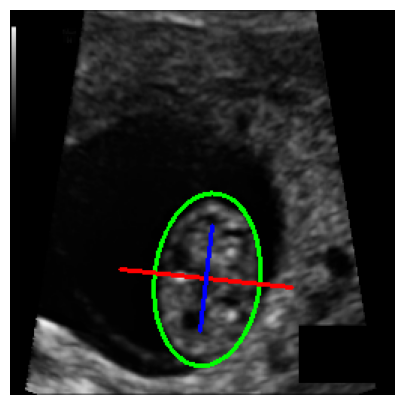

In [ ]:
vis = (img.squeeze().numpy() * 255).astype(np.uint8)
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

cv2.ellipse(vis, ellipse, (0, 255, 0), 2)
cv2.line(vis, *ofd_pts, (255, 0, 0), 2)
cv2.line(vis, *bpd_pts, (0, 0, 255), 2)

plt.figure(figsize=(5,5))
plt.imshow(vis)
plt.axis("off")
plt.show()
